In [54]:
import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import ProcessGenMetrics
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass

@dataclass(frozen=False)
class PerInstanceStats:
    """
    Captures a unit of evaluation.
    """

    # Uniquely identifies the input instance
    instance_id: str
    train_trial_index: int
    """Which replication"""

    stats: List[Stat]
    """Statistics computed from the predicted output"""
    perturbation: Optional[PerturbationDescription]=None



def get_gen_summary(path) -> GenerationSummary:
    def json_to_instance_generation(instance_dict:dict) -> InstanceGenerations:
        def json_to_generated_output(generated_output_dict):
            generated_output=GeneratedOutput(**generated_output_dict)
            tokens = [Token(**token) for token in generated_output.tokens]
            generated_output.tokens=tokens
            return generated_output
        instance_generation = InstanceGenerations(**instance_dict)
        examples = [ json_to_generated_output(generated_output_dict) for generated_output_dict in instance_generation.examples]
        instance_generation.examples=examples
        return instance_generation
    with open(path,'r') as json_file:
        generation_summary_dict=json.load(json_file)
    generation_summary=GenerationSummary(**generation_summary_dict)
    instance_generations = [json_to_instance_generation(instance_dict)  for instance_dict in generation_summary.instance_generations ]
    generation_summary.instance_generations=instance_generations
    return generation_summary

def truncate_sequence(text:str, all_stops=["<|end_of_text|>"]) -> str:
    for stop in all_stops:
        try:
            text = text[: text.index(stop)]
        except ValueError:
            pass
    return text.strip()

class ProcessGens:
    base_folder:str
    beam_num_to_summary:Dict[int, GenerationSummary]
    metrics_dict:List[Dict[str,any]]

    def __init__(self,base_folder:str, num_beams_list:List[int], models:List[float], custom_metrics:List[ProcessGenMetrics.PostMetric],task_name:str, eval_instances:str=None, instance_metrics:Dict[int, Dict[str, Dict[str, float]]]=None):
        

        self.base_folder=base_folder

        # #these are by themselves
        print("get_metrics_df")
        metrics_df=self.get_metrics_df(base_folder)
        print("get_instance_info")
        instance_info=self.get_instance_info(base_folder=base_folder, num_beams_list=num_beams_list, models=models,task_name= task_name, eval_instances=eval_instances)


        beam_num_to_instance_stats=self.calculate_beam_num_to_run_instance_stats(base_folder=base_folder, num_beams_list=num_beams_list, models=models, task_name=task_name, eval_instances=eval_instances, instance_metrics=instance_metrics)
        # self.metrics_df=metrics_df
        self.instance_info=instance_info

        #these go together
        print("calculate_beam_num_to_summary")
        beam_num_to_summary=self.calculate_beam_num_to_summary(base_folder=base_folder, num_beams_list=num_beams_list, models=models,eval_instances=eval_instances,task_name=task_name)
        print("get_metrics_dict")
        metrics_dicts=self.get_metrics_dict(beam_num_to_summary=beam_num_to_summary, custom_metrics=custom_metrics, beam_num_to_instance_stats=beam_num_to_instance_stats)

        self.beam_num_to_instance_stats=beam_num_to_instance_stats
        self.beam_num_to_summary=beam_num_to_summary
        self.metrics_dicts=metrics_dicts
        self.metrics_df=metrics_df

    
    def calculate_beam_num_to_run_instance_stats(self, base_folder, num_beams_list:List[int], models:List[float], task_name:str, eval_instances:int, instance_metrics:Dict[int, Dict[str, Dict[str, float]]])->Dict[int, List[PerInstanceStats]]:
        def json_to_run_instance_stats(path, instance_metrics) -> List[PerInstanceStats]:
            with open(path,'r') as json_file:
                list_instance_stats_dicts=json.load(json_file)
            
            instance_id_to_stats_dict={}
            for list_instance_stats_dict in list_instance_stats_dicts:
                per_instance_stats = PerInstanceStats(**list_instance_stats_dict)
                stats = [Stat(**stat_dict) for stat_dict in per_instance_stats.stats]
                per_instance_stats.stats=stats
                stats_dict={}
                for stat in per_instance_stats.stats:
                    name = stat.name
                    if name["name"] in instance_metrics and name["split"]=="test" and "perturbation" not in name.keys():
                        stats_dict[name["name"]]= stat.mean
                instance_id_to_stats_dict[per_instance_stats.instance_id]=stats_dict
            return instance_id_to_stats_dict
        
        beam_num_to_run_instance_stats= {}
        for num_beams in num_beams_list:
            for model in models:
                path=f"{base_folder}/{task_name}/{model}/{num_beams}_beams/runs/eval_{eval_instances}/per_instance_stats.json"
                print(f"Analyzing path: {path}")
                run_instance_stats = json_to_run_instance_stats(path, instance_metrics)
                beam_num_to_run_instance_stats[num_beams]=run_instance_stats
        return beam_num_to_run_instance_stats

    def clean_generation_summary(generationSummary:GenerationSummary, eval_instances)->GenerationSummary:
        def clean_instance_generation(instanceGenerations:InstanceGenerations)->InstanceGenerations:
            def clean_generated_output(generatedOutput:GeneratedOutput)-> GeneratedOutput:
                generatedOutput.text=truncate_sequence(generatedOutput.text)
                return generatedOutput
            instanceGenerations.examples=[clean_generated_output(example) for example in instanceGenerations.examples]

            instanceGenerations.examples.sort(key=lambda x:float(x.logprob),reverse=True)
            completion=instanceGenerations.examples[0]
            instanceGenerations.completion=completion.text
            instanceGenerations.completion_logprob=completion.logprob
            return instanceGenerations
        generationSummary.instance_generations=[clean_instance_generation(instance_generation) for instance_generation in generationSummary.instance_generations]
        assert len(generationSummary.instance_generations)==eval_instances
        print(f"number of instances: {len(generationSummary.instance_generations)}")
        generationSummary.instance_generations=generationSummary.instance_generations[:eval_instances]
        return generationSummary



    @classmethod  
    def get_instance_info(self, base_folder, num_beams_list:List[int], models:List[float], task_name: str, eval_instances:int)->Dict[int, GenerationSummary]:
        num_beams=num_beams_list[0]
        model=models[0]
        instance_infos= {}
        instance_metrics=[ProcessGenMetrics.ReferenceMetric()]
        path=f"{base_folder}/{task_name}/{model}/{num_beams}_beams/runs/eval_{eval_instances}/generation_summary.json"
        generation_summary=get_gen_summary(path)
        for instance_generation in generation_summary.instance_generations:
            instance_id=instance_generation.instance_id
            if instance_id not in instance_infos.keys():
                instance_dict={}
                for metric in instance_metrics:
                    ProcessGenMetrics.calculate_post_metric(instance_dict,metric,instance_generation,None)
                instance_infos[instance_id]=instance_dict
        return instance_infos

    @classmethod  
    def calculate_beam_num_to_summary(self, base_folder, num_beams_list:List[int], models:List[float], task_name: str,eval_instances:int)->Dict[int, GenerationSummary]:
        beam_num_to_summary= {}
        for num_beams in num_beams_list:
            for model in models:
                path=f"{base_folder}/{task_name}/{model}/{num_beams}_beams/runs/eval_{eval_instances}/generation_summary.json"
                print(f"Analyzing path: {path}")
                raw_generation_summary=get_gen_summary(path)
                
                generation_summary:GenerationSummary=self.clean_generation_summary(raw_generation_summary, eval_instances)
                # if(eval_instances):
                    # assert len(generation_summary.instance_generations)==eval_instances
                beam_num_to_summary[num_beams]=generation_summary
        return beam_num_to_summary

    @classmethod  
    def get_metrics_dict(self, beam_num_to_summary:Dict[int, GenerationSummary], custom_metrics:List[ProcessGenMetrics.PostMetric], beam_num_to_instance_stats: Dict[int, Dict[str, Dict[str, float]]]):
        base_metrics=[ProcessGenMetrics.TextMetric,ProcessGenMetrics.SentenceLenMetric(),ProcessGenMetrics.OutputProbMetric(),
                       ProcessGenMetrics.InstanceIdMetric(), ProcessGenMetrics.IsCompletionMetric()]
        metrics=base_metrics+custom_metrics
        metrics_dicts=[]
        for beam_num, generation_summary in beam_num_to_summary.items():
            print(beam_num)
            for instance_generation in generation_summary.instance_generations:
                
                for idx,generated_output in enumerate(instance_generation.examples):
                    pd_metrics_dict={}
                    for metric in metrics:
                        ProcessGenMetrics.calculate_post_metric(pd_metrics_dict,metric,instance_generation,generated_output)
                    pd_metrics_dict["beam_num"]=beam_num
                    if(idx==0):
                        pd_metrics_dict["isCompletion"]=(idx==0)
                        completion_metrics_dict = beam_num_to_instance_stats[beam_num][instance_generation.instance_id]
                        for stat_name, value in completion_metrics_dict.items():
                            pd_metrics_dict[stat_name]= value
                    metrics_dicts.append(pd_metrics_dict)
        return metrics_dicts

    @classmethod  
    def get_metrics_df(self, base_folder):

        try:
            metrics_file=f"{base_folder}/metrics_csv.txt"
            raw_metric_df = pd.read_csv(metrics_file, header=None)
            raw_metric_df.columns=[ "model", "task", "beam_num", "metric", "value"]
            raw_metric_df.drop(["task"],axis=1)
            metric_df = raw_metric_df.pivot(
                index=["model", "beam_num"],
                columns="metric",
                values="value"
            ).reset_index()
            metric_df.sort_values("beam_num")
            self.metric_df=metric_df
            return metric_df
        except:
            return None


In [55]:
# # copied snellius test
# num_beams_list=[2,4, 128]
# models=["meta_llama_Llama_3.1_8B_Instruct"]
# eval_instances=40
# root_folder=f"snellius_copies/wmt_test"


# #local test
# num_beams_list=[15,20]
# root_folder="helm_output"
# eval_instances=3
# models=["distilbert_distilgpt2"]

# copied snellius run
num_beams_list=[2,4,8,16,32,64,128]
models=["meta_llama_Llama_3.1_8B_Instruct"]
eval_instances=1000
root_folder=f"snellius_copies/full"
task_name="wmt"

instance_metrics=["comet"]



base_folder=f"{root_folder}/eval_{eval_instances}"
custom_metrics=[ ProcessGenMetrics.BLEU1_METRIC(),ProcessGenMetrics.BLEU4_METRIC()]
processGens= ProcessGens(base_folder=base_folder,num_beams_list=num_beams_list,models=models,custom_metrics=custom_metrics,task_name="wmt", eval_instances=eval_instances, instance_metrics=instance_metrics)


# code snellius_copies/wmt_test/eval_4/wmt/meta_llama_Llama_3.1_8B_Instruct/2_beams/runs/eval_4/generation_summary.json
# code snellius_copies/wmt_test/eval_4/wmt/meta_llama_Llama_3.1_8B_Instruct/128_beams/runs/eval_4/generation_summary.json




get_metrics_df
get_instance_info
Analyzing path: snellius_copies/full/eval_1000/wmt/meta_llama_Llama_3.1_8B_Instruct/2_beams/runs/eval_1000/per_instance_stats.json
Analyzing path: snellius_copies/full/eval_1000/wmt/meta_llama_Llama_3.1_8B_Instruct/4_beams/runs/eval_1000/per_instance_stats.json
Analyzing path: snellius_copies/full/eval_1000/wmt/meta_llama_Llama_3.1_8B_Instruct/8_beams/runs/eval_1000/per_instance_stats.json
Analyzing path: snellius_copies/full/eval_1000/wmt/meta_llama_Llama_3.1_8B_Instruct/16_beams/runs/eval_1000/per_instance_stats.json
Analyzing path: snellius_copies/full/eval_1000/wmt/meta_llama_Llama_3.1_8B_Instruct/32_beams/runs/eval_1000/per_instance_stats.json
Analyzing path: snellius_copies/full/eval_1000/wmt/meta_llama_Llama_3.1_8B_Instruct/64_beams/runs/eval_1000/per_instance_stats.json
Analyzing path: snellius_copies/full/eval_1000/wmt/meta_llama_Llama_3.1_8B_Instruct/128_beams/runs/eval_1000/per_instance_stats.json
calculate_beam_num_to_summary
Analyzing path:

/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

4
8
16
32
64
128


In [56]:
import statistics
summaries=[processGens.beam_num_to_summary[beam_num] for beam_num in [num_beams_list[0],num_beams_list[-1]] ]

def get_text(example):
    return " ".join([token.text for token in example.tokens])

diffs=[]
for idx,instancesA in enumerate(summaries[0].instance_generations):
    instanceB= summaries[1].instance_generations[idx]
    for exampleA in instancesA.examples:
        for exampleB in instanceB.examples:
            if(get_text(exampleA)==get_text(exampleB)):
                logprobA=exampleA.logprob #.logprob
                logprobB=exampleB.logprob #.logprob
                print(f"text {get_text(exampleA)}")
                diff=abs((logprobA-logprobB)/min(logprobA,logprobB))
                print(f"logprobA: {logprobA}, logprobB: {logprobB}, diff: {diff}")
                diffs.append(diff)
                
                # assert diff<0.1
print(statistics.mean(diffs))
print(max(diffs))
            

text  He  advised  the  parents  of  a  boy  whose  penis  had  been  severed  in  a  bot ched  circumcision  to  ca strate  the  child  completely  and  remove  his  test icles  and  then  raise  him  as  a  girl . <|end_of_text|>
logprobA: -25.499141977750696, logprobB: -25.499082293943502, diff: 2.3406202156256908e-06
text  He  advised  the  parents  of  a  boy  whose  penis  had  been  severed  during  a  bot ched  circumcision  to  ca strate  the  child  completely  and  remove  his  test icles  and  then  raise  him  as  a  girl . <|end_of_text|>
logprobA: -25.54776585806394, logprobB: -25.54771142062964, diff: 2.1308099738826114e-06
text  Airbus  states  that  the  competing  version  of  the  A 350  carries   350  people  in   18 -inch  seats  in  economy  class ,  with  nine  per  row . <|end_of_text|>
logprobA: -23.972597687505186, logprobB: -23.97204847773537, diff: 2.290989808340468e-05
text  Airbus  states  that  the  competing  version  of  the  A 350  will  carry   350  

In [57]:
#investigation of two different ones
#     for textA, logprobA in text_to_log_probA.items():
#         for textB, logprobB in text_to_log_probB.items():
#             if(textA==textB):
#             print("textA: ",textA)
#             diff=abs((logprobA-logprobA)/min(logprobA,logprobB))
#             print(f"logprobA: {logprobA}, logprobB: {logprobB}, diff: {diff}")
#             assert diff<0.05

#  example1:GeneratedOutput=processGens.beam_num_to_summary[2].instance_generations[0].examples[0]
# example2:GeneratedOutput=processGens.beam_num_to_summary[128].instance_generations[0].examples[0]
# token_texts=[]
# for example in [example1, example2]:

#     prob_sum = sum([token.logprob for token in example.tokens ])
#     token_text = " ".join([token.text for token in example.tokens ])
#     # print(example.keys())
#     logprob = example.logprob
#     print(f"text: {example.text}")
#     print(f"prob_sum: {prob_sum}")
#     print(f"logprob: {logprob}")
#     token_texts.append(token_text)

# assert(example1.text==example2.text)
# assert(token_texts[0]==token_texts[1])

# assert len(example1.tokens)== len(example2.tokens)
# for i in range(len(example1.tokens)):
#     token1=example1.tokens[i]
#     token2=example2.tokens[i]
#     print(f"i is {i}")
#     print(f"{token1['logprob']} vs {token2['logprob']} ")
#     percent_diff=abs((token1.logprob-token2.logprob)/token1.logprob)
#     print(f"percent_diff is {percent_diff}")
#     assert token1.text==token2.text
#     assert percent_diff<0.05

# sum1=0
# sum2=0

# sum1s=[]
# sum2s=[]
# diffs=[]
# for i in range(len(example1.tokens)):
#     sum1+=example1.tokens[i].logprob
#     sum2+=example2.tokens[i].logprob
#     # print(f"{sum1} vs {sum2}")
#     sum1s.append(sum1)
#     sum2s.append(sum1)
#     diffs.append(sum1-sum2)

# import matplotlib.pyplot as plt
# import numpy as np

# fig,ax = plt.subplots(1)
# x=np.arange(len(example1.tokens))
# ax.plot(x,diffs)
# ax.plot(x,sum2s)





In [58]:
import statistics

def analyze_completion_by_beam(num_instances):
    first_beam=next(iter(num_beams_list))
    ids=[instance_generations.instance_id for instance_generations in processGens.beam_num_to_summary[first_beam].instance_generations]
    for id in ids[:num_instances]:
        print("\n")
        for beam_num in num_beams_list:
            for instance_generation in processGens.beam_num_to_summary[beam_num].instance_generations:
                if(instance_generation.instance_id==id):
                    max_logprobs=max([example.logprob for example in instance_generation.examples])
                    # print(f"beam_num:{beam_num}\t log_prob:{instance_generation.completion_logprob}")
                    print(f"beam_num:{beam_num}  \t max_p:{instance_generation.completion_logprob}\tcompletion:{instance_generation.completion}")
num_instances=1000
analyze_completion_by_beam(num_instances)



beam_num:2  	 max_p:-25.499141977750696	completion:He advised the parents of a boy whose penis had been severed in a botched circumcision to castrate the child completely and remove his testicles and then raise him as a girl.
beam_num:4  	 max_p:-25.499141868785955	completion:He advised the parents of a boy whose penis had been severed in a botched circumcision to castrate the child completely and remove his testicles and then raise him as a girl.
beam_num:8  	 max_p:-25.499125962727703	completion:He advised the parents of a boy whose penis had been severed in a botched circumcision to castrate the child completely and remove his testicles and then raise him as a girl.
beam_num:16  	 max_p:-25.49912476411555	completion:He advised the parents of a boy whose penis had been severed in a botched circumcision to castrate the child completely and remove his testicles and then raise him as a girl.
beam_num:32  	 max_p:-25.499124448397197	completion:He advised the parents of a boy whose peni

In [59]:



def get_beam_probs():
    for beam_num in num_beams_list:
        max_log_probs=[]
        for instance_generation in processGens.beam_num_to_summary[beam_num].instance_generations:
            example_logprobs=[example.logprob for example in instance_generation.examples]
            max_log_probs.append(max(example_logprobs))
        print(f"beam num: {beam_num}. \tAve:{statistics.mean(max_log_probs)}")
    
def get_beam_means():
    for beam_num in num_beams_list:
        data=[]
        for instance_generation in processGens.beam_num_to_summary[beam_num].instance_generations:
            data.append(len(instance_generation.completion))
        print(f"beam num: {beam_num}. \tAve:{statistics.mean(data)}")
     
# id24769
def analyze_output_by_instance(beam_num, num_instances, num_examples):
    for instance_generation in processGens.beam_num_to_summary[beam_num].instance_generations[:num_instances]:
        print(f"\n\nid: {instance_generation.instance_id}\t reference {instance_generation.reference}")
        for example in instance_generation.examples[:num_examples]:
            print(f"\tp:{example.logprob}\ttext:{example.text}")


def see_overlap_per_instance_generation(beam_num, num_instances):
    for instance_generation in processGens.beam_num_to_summary[beam_num].instance_generations[:num_instances]:
        texts=[example.text for example in instance_generation.examples]
        probs=[example.logprob for example in instance_generation.examples]

        print(f"id: {instance_generation.instance_id}\tn_unique_text: {len(set(texts))}\tn:{len(set(probs))}\tn_unique_probs")




def get_instance_generations_by_id():
    ids=[instance_generations.instance_id for instance_generations in processGens.beam_num_to_summary[2].instance_generations]

    #dict id --) beam_num --) instance_generation
    instance_generations_by_id={}
    for id in ids[:10]:
        instance_generations_by_id[id]={}
        
        for beam_num in num_beams_list:
        
            for instance_generation in processGens.beam_num_to_summary[beam_num].instance_generations:
                if(instance_generation.instance_id==id):
                    instance_generations_by_id[id][beam_num]=instance_generation
    return instance_generations_by_id




def check_completion_logprob(beam_num):
    for instance_generation in processGens.beam_num_to_summary[beam_num].instance_generations:
        completion_logprob=instance_generation.completion_logprob
        for example in instance_generation.examples:
            assert example.logprob<=completion_logprob

def check_sentence_logprob(beam_num, num_instances=10, num_examples=10):
    for instance_generation in processGens.beam_num_to_summary[beam_num].instance_generations[:num_instances]:
        completion_logprob=instance_generation.completion_logprob
        for example in instance_generation.examples[:num_examples]:
            assert example.logprob<=completion_logprob



def beam_diff_check():
    instance_generations_by_id=get_instance_generations_by_id()
    for instance_idx, instance_generation_by_beam_num in instance_generations_by_id.items():
        # print(type(instance_generation_by_beam_num))

        for idx2, beam2_example in enumerate(instance_generation_by_beam_num[2].examples):
            for idx128, beam128_example in enumerate(instance_generation_by_beam_num[128].examples):
                if(beam2_example.text==beam128_example.text):
                    p1=beam2_example.logprob
                    p2=beam128_example.logprob
                    diff= abs(  (p1-p2)/ min(p1,p2) )
                    
                    print(f"Match! Beam2: {p1} vs {p2} is {diff}, {instance_idx} {idx2}, {idx128}")
                    assert(diff<0.1)

beam_num=next(iter(processGens.beam_num_to_summary))
# instance_generations_by_id=get_instance_generations_by_id()
# get_beam_means()
# get_beam_probs()
check_completion_logprob(beam_num)
check_sentence_logprob(beam_num)






In [60]:
if(processGens.metrics_df is not None):
    ax1 = processGens.metrics_df.plot.scatter(x='beam_num',y='comet',c='DarkBlue')


In [61]:
import pandas as pd
examples_df = pd.DataFrame(processGens.metrics_dicts)
completions_df=examples_df.loc[examples_df['isCompletion'] == True]

print(completions_df.columns)
print(f"Num examples: {examples_df.shape[0]}")
print(f"Num completions: {completions_df.shape[0]}")

if(eval_instances):
    assert sum(num_beams_list)*eval_instances==examples_df.shape[0]
    assert len(num_beams_list)*eval_instances==completions_df.shape[0]


Index(['text', 'completion_length', 'output_logprob', 'instanceID',
       'isCompletion', 'BLEU_1', 'BLEU_4', 'beam_num', 'comet'],
      dtype='object')
Num examples: 254000
Num completions: 7000


Mean output_logprob for 128:	 -18.807477946530195
Mean output_logprob for 2:	 -23.16285447239389
Mean Change:-4.355376525863696
Median Change:-3.203652821597643


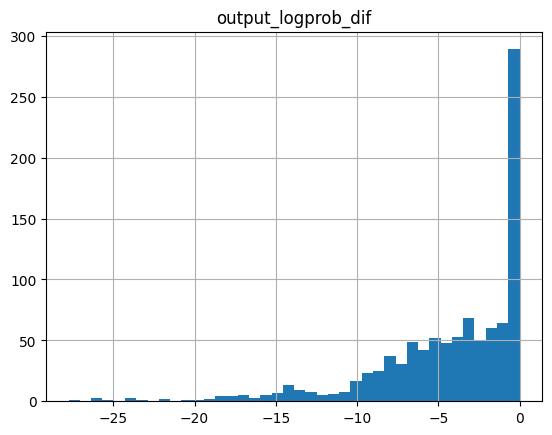

In [62]:
def compare_beams_by_metric(analysis_df,compare_metric,compare_beams, compare_func= lambda a,b: a-b,plot_histogram=True):

    for beam_num in compare_beams:
        filtered_df=analysis_df.loc[analysis_df['beam_num']==beam_num]
        print(f"Mean {compare_metric} for {beam_num}:\t {filtered_df[compare_metric].mean()}")
    col_names=[f"{compare_metric}_{beam_num}" for beam_num in compare_beams]
    dif_col=f'{compare_metric}_dif'

    result = analysis_df[analysis_df['beam_num'].isin(compare_beams)][['instanceID', 'beam_num', compare_metric]]
    pivoted = result.pivot(index='instanceID', columns='beam_num', values=compare_metric)
    pivoted.columns = col_names
    pivoted = pivoted.reset_index()
    pivoted[dif_col] = pivoted.apply(lambda row: compare_func(row[col_names[0]],row[col_names[1]]), axis=1)
    print(f"Mean Change:{pivoted[dif_col].mean()}")
    print(f"Median Change:{pivoted[dif_col].median()}")
    if(plot_histogram):
        pivoted.hist(column=dif_col,bins=40)

last_beam=num_beams_list[-1]
first_beam=num_beams_list[0]
compare_beams_by_metric(analysis_df=completions_df,compare_metric='output_logprob', compare_beams=[last_beam, first_beam])



In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_keys(xlabel, ylabel):
    x=metric_df[xlabel]
    y=df[ylabel]
    plt.scatter(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.show()

plot_keys("completion_logprob","BLEU")


NameError: name 'metric_df' is not defined

In [35]:


# for instance_generation in instance_generations:
#     for generated_output in instance_generation.examples:
#         if(generated_output.logprob>-50):
#             instance_generation.reference
#             print(generated_output.text)
#             print(" ".join([token.text for token in generated_output.tokens]))

 Airbus states that the competing version of the A350 carries 350 people in 18-inch seats in economy class, with nine per row.
 Airbus  states  that  the  competing  version  of  the  A 350  carries   350  people  in   18 -inch  seats  in  economy  class ,  with  nine  per  row . <|end_of_text|>
 According to the Associated Press, the target was Russian SA-125 missiles.
 According  to  the  Associated  Press ,  the  target  was  Russian  SA - 125  missiles . <|end_of_text|>
 The text, which was adopted last night, consists of 234 articles.
 The  text ,  which  was  adopted  last  night ,  consists  of   234  articles . <|end_of_text|>
 The text that was adopted last night consists of 234 articles.
 The  text  that  was  adopted  last  night  consists  of   234  articles . <|end_of_text|>
 He only stirs up enthusiasm with difficulty.
 He  only  st irs  up  enthusiasm  with  difficulty . <|end_of_text|>
 He only rarely inspires enthusiasm.
 He  only  rarely  inspires  enthusiasm . <|end_

: 